In [1]:
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
import pathlib
%matplotlib inline
from matplotlib import pyplot as plt
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.1,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)

output_suffix = ""
output_formats = [".png", ".pdf"]

sc.set_figure_params(dpi_save=150, frameon=False,
 vector_friendly=True, fontsize=6, figsize=(3,3), format='pdf', transparent=True)

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2
%run ../helper.py
sns.set_style("ticks")
plt.style.use('../bursa.mplstyle')

## Load the Data

In [2]:
# configuration:
h5ad = '../../../data/bcells.h5ad.gz'
tissue_combo = 'LN_SP'
restrict_to_TBd6 = True
# Flag to control the sharing computation, takes a while only needs done once
compute_sharing = False
vdj_infile = '../../../data/integrated_cell_calls_ambient_annotated.tsv.gz'
sharing_outfile = "../annotate/outputs/sharing_labels_gex.tsv.gz"
mb_subtypes = "../annotate/outputs/MB_subtypes.tab"
seq_identifier = 'vdj_sequence'
# Dictionary to map tissue_combo to DataFrame columns
tissue_combo_to_column = {
    'LN_LN': 'shared_LN_LN',
    'LN_SP': 'shared_LN_SP',
    'LN_PB': 'shared_LN_PB',
    "BM_PB": 'shared_BM_PB'
    # Add more mappings as needed
}


In [3]:
adata = sc.read_h5ad(h5ad, backed = 'r')


In [4]:
# subset to donor 6, the only one with multiple lymph nodes
if restrict_to_TBd6:
    adata = adata[adata.obs.donor == 'TBd6']
adata = adata.to_memory()
# map whether the IGHC is switched
adata.obs.loc[:,"switched"] = adata.obs.c_call.map(IGH_switched())
# remove GEX profiles without VDJ sequences
adata = adata[adata.obs.vdj_sequence != 'nan']
# use only a subset of the data that is relevant for merge
adata.obs = adata.obs[['cb', 'vdj_sequence', 'celltypist', 'switched']]


In [5]:
if compute_sharing:
    # Load the data
    df = pd.read_table(vdj_infile, index_col=0, usecols=["vdj_sequence", "lineage_id", 'v_mismatch', 'donor', 'probable_hq_single_b_cell', 'subanatomical_location', 'tissue', 'locus', 'c_call', 'sample_uid', 'cb'])

    # Drop rows with missing 'locus'
    df = df.dropna(subset=['locus'])

    # Subset to LNs
    df_LN = df[df.tissue == 'LN']

    # Print value counts for subanatomical locations within LNs
    print(df_LN.subanatomical_location.value_counts())

    # Identify sequences shared between LNs
    shared_LNs = df_LN.groupby(seq_identifier)['subanatomical_location'].nunique() > 1
    df['shared_LN_LN'] = df[seq_identifier].map(shared_LNs)

    # Identify sequences found in a single LN
    found_single_LN = df_LN.groupby(seq_identifier)['subanatomical_location'].nunique() == 1
    df['found_in_single_LN'] = df[seq_identifier].map(found_single_LN)

    # Function to check if two specific locations are shared within a group
    def shared_locations(group, subanatomical, loc1, loc2):
        if subanatomical == False:
            return (loc1 in group['tissue'].values) and (loc2 in group['tissue'].values)
        else:
            return (loc1 in group['subanatomical_location'].values) and (loc2 in group['subanatomical_location'].values)

    # Dictionary to hold shared categories
    shared_categories = {
        'shared_LN_SP': {'subanatomical': False, 'loc1': 'LN', 'loc2': 'SP'},
        'shared_SP_PB': {'subanatomical': False, 'loc1': 'SP', 'loc2': 'PB'},
        'shared_BM_PB': {'subanatomical': False, 'loc1': 'BM', 'loc2': 'PB'},
        'shared_LN_PB': {'subanatomical': False, 'loc1': 'LN', 'loc2': 'PB'},
        'shared_LN_BM': {'subanatomical': False, 'loc1': 'LN', 'loc2': 'BM'},
    }
    # Iterate through the dictionary to compute shared categories
    for category, params in shared_categories.items():
        shared = df.groupby(seq_identifier).apply(shared_locations, params['subanatomical'], params['loc1'], params['loc2'])
        df[category] = df[seq_identifier].map(shared)
    # Write the DataFrame to a file
    df.reset_index().to_csv(sharing_outfile, sep="\t")
# load output
shared = pd.read_table(sharing_outfile, index_col = 0)
print(shared.shape, "antibody assemblies to analyze for sharing")
shared = shared[shared.probable_hq_single_b_cell == True]
print(shared.shape, "number of hq single B cells transcriptomes to detect GEX differences amongst shared cells")
# Merging the DataFrames with suffixes for common columns
merged_df = pd.merge(adata.obs, shared, left_on=['cb', 'vdj_sequence'], right_on=['cb', 'vdj_sequence'], suffixes=('_left', ''), how='left')

# Dropping the columns duplicated columns for df on right
# Identify columns containing "_right" in their names
cols_to_remove = [col for col in merged_df.columns if '_left' in col]

# Drop the identified columns from the DataFrame
merged_df.drop(columns=cols_to_remove, inplace=True)
merged_df.index = adata.obs.index
adata.obs = merged_df
adata = adata[~adata.obs.sample_uid.isna()]
# Set 'shared' column based on tissue_combo
if tissue_combo in tissue_combo_to_column:
    column_name = tissue_combo_to_column[tissue_combo]
    adata.obs['shared'] = adata.obs[column_name].astype('category')
else:
    print(f"Warning: {tissue_combo} not found in mapping.")

# Display value counts for the 'shared' column
print(adata.obs.shared.value_counts())

# set output figure directory for different tissue combos
figure_output_dir = f"/home/michaelswift/repos/tabula-bursa/analysis/figures/shared_mb/{tissue_combo}"
file_output_dir = f"outputs"
pathlib.Path(figure_output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".pdf"]
sc.settings.figdir = figure_output_dir
def save_figure(
    fig,
    name,
    output_dir=figure_output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            figure_output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None

/tmp/ipykernel_7130/1338740983.py:3: DtypeWarning: Columns (2,4,5,76,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(vdj_infile, index_col=0, usecols=["vdj_sequence", "lineage_id", 'v_mismatch', 'donor', 'probable_hq_single_b_cell', 'subanatomical_location', 'tissue', 'locus', 'c_call', 'sample_uid', 'cb'])


subanatomical_location
SDLN1    146273
SDLN3     56045
SDLN2     46962
MELN1     33967
MELN      26779
Name: count, dtype: int64


/tmp/ipykernel_7130/1338740983.py:44: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  shared = pd.read_table(sharing_outfile, index_col = 0)


(1160737, 18) antibody assemblies to analyze for sharing
(202489, 18) number of hq single B cells transcriptomes to detect GEX differences amongst shared cells


/tmp/ipykernel_7130/1338740983.py:63: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['shared'] = adata.obs[column_name].astype('category')


shared
False    47108
True      2355
Name: count, dtype: int64


In [6]:
# Subset to Memory B cells
mb_adata = adata[adata.obs.celltypist.str.contains('Memory B|Age|Prolif')]
print(mb_adata.obs.shape, "Memory B cells to analyze")
# add the memB subtype labels
labels = pd.read_table(mb_subtypes, index_col = 0)
mb_adata.obs = pd.merge(mb_adata.obs, labels, left_index=True, right_index=True, how='left')
mb_adata_LN = mb_adata[mb_adata.obs.tissue == 'LN']

(12710, 21) Memory B cells to analyze


## Calculate DE genes between the groups

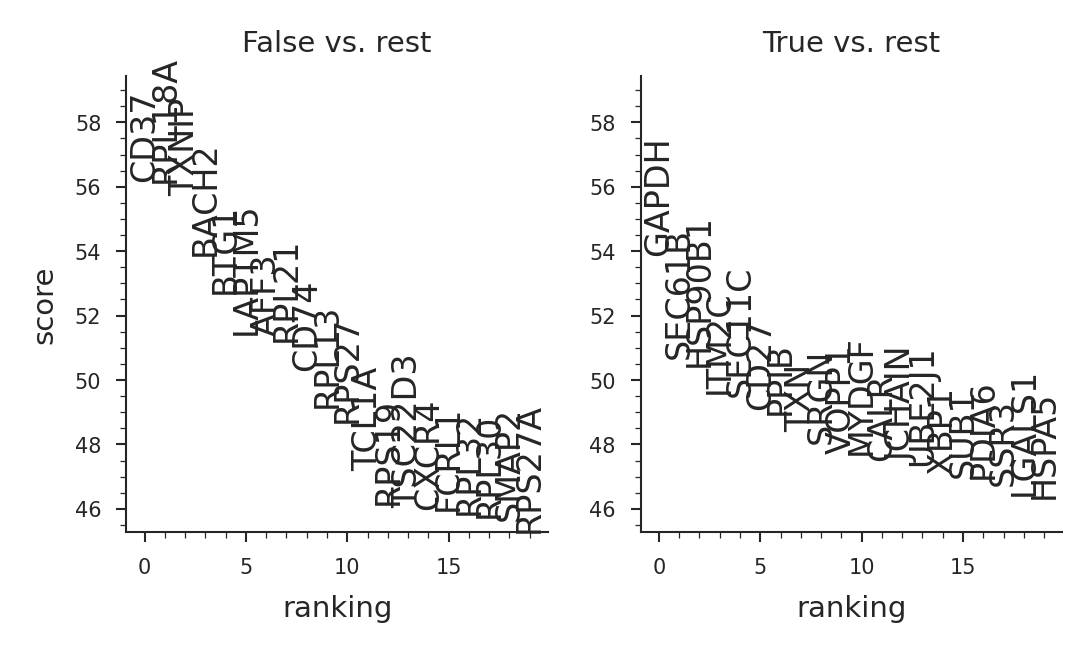

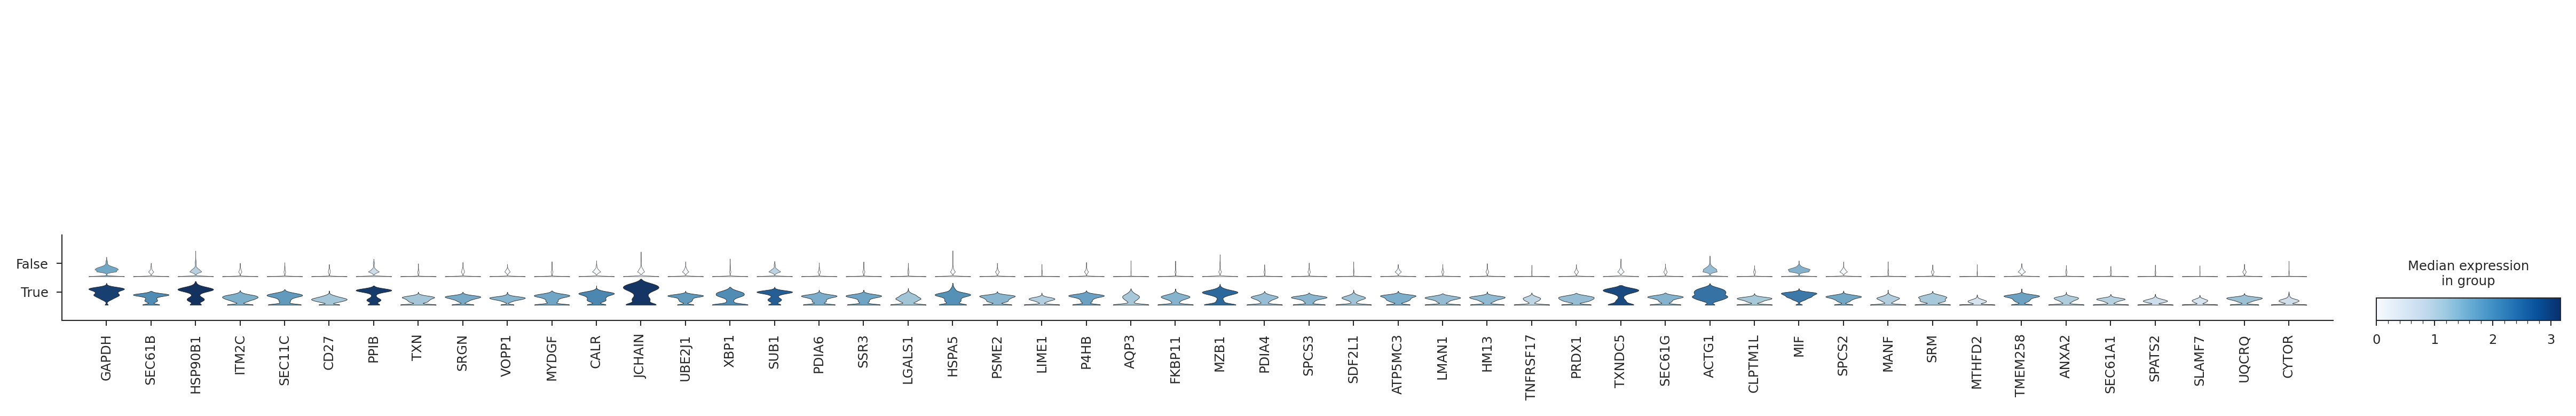

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


probably no subtype information in this adata


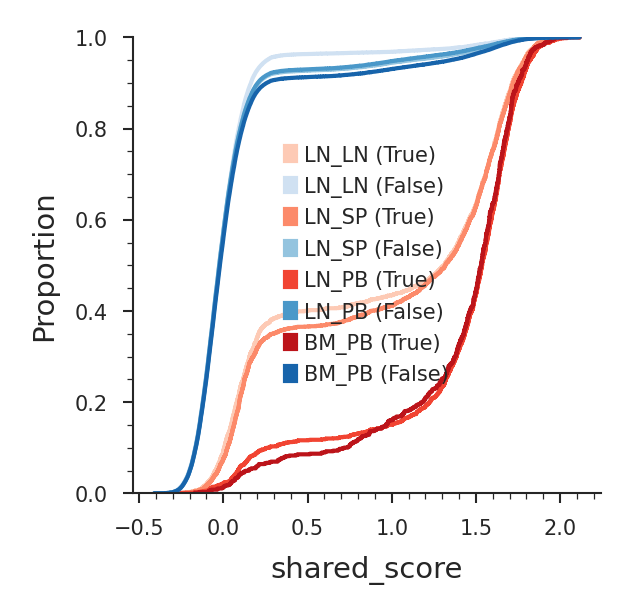

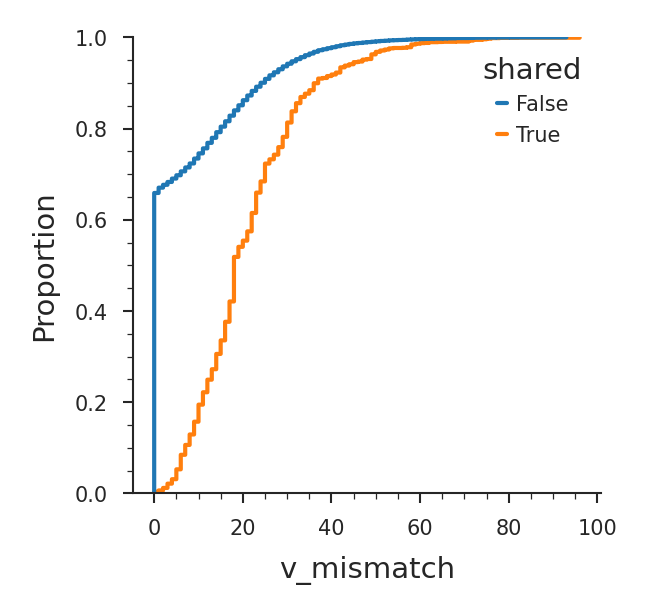

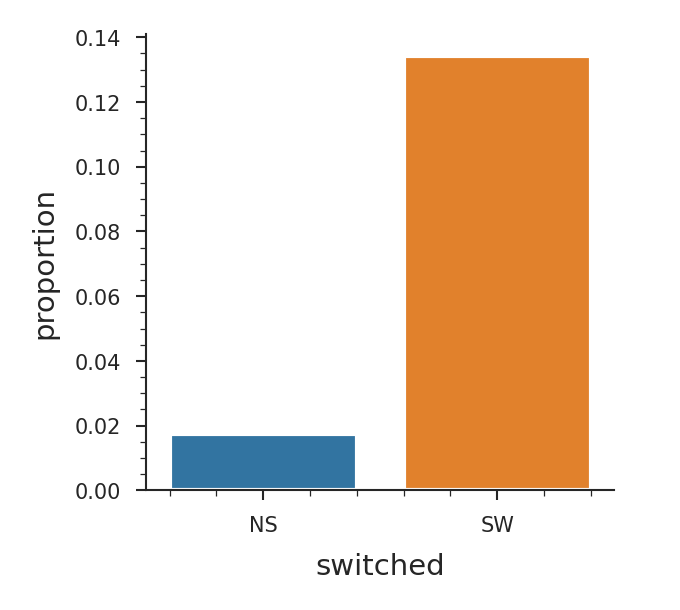

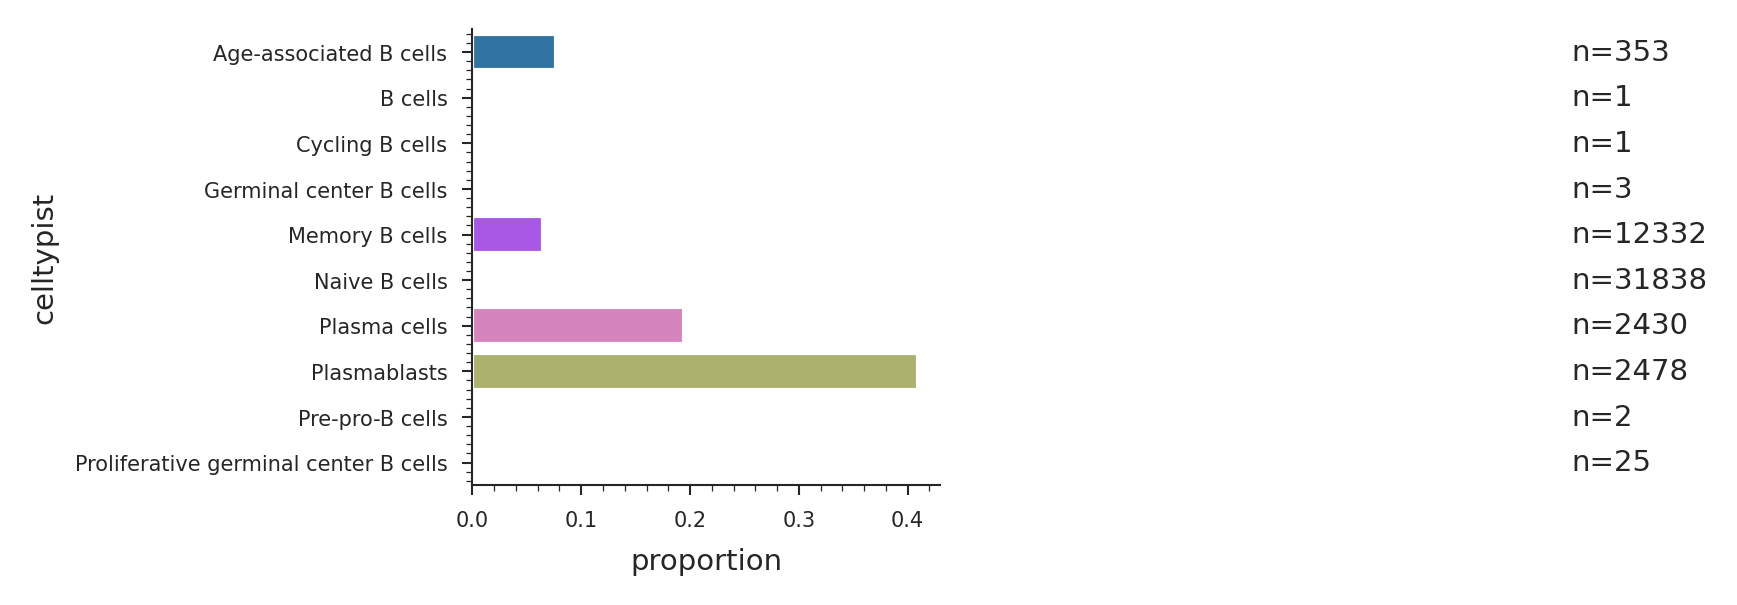

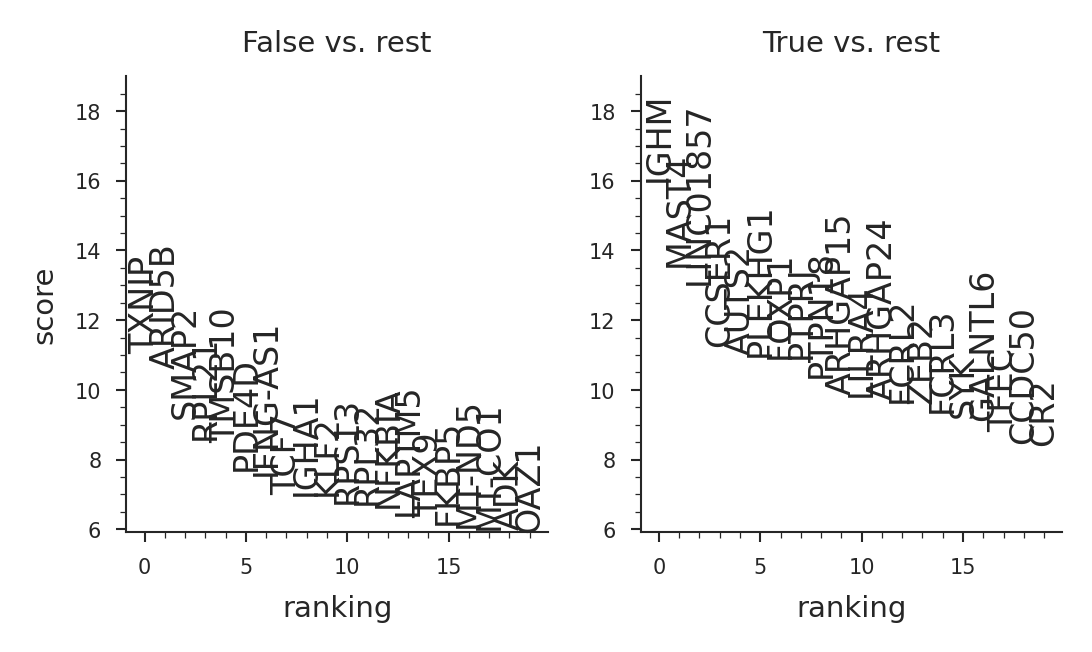

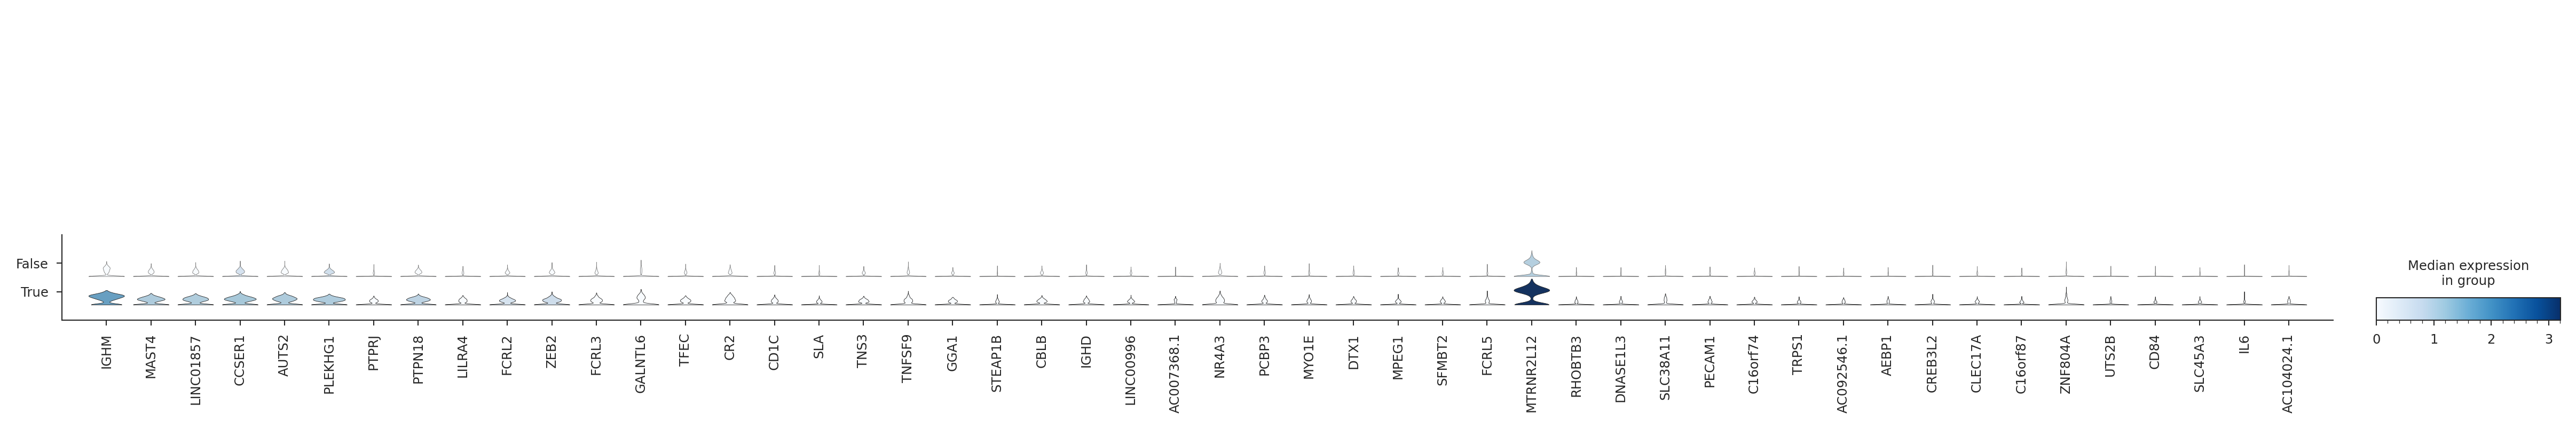

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, in

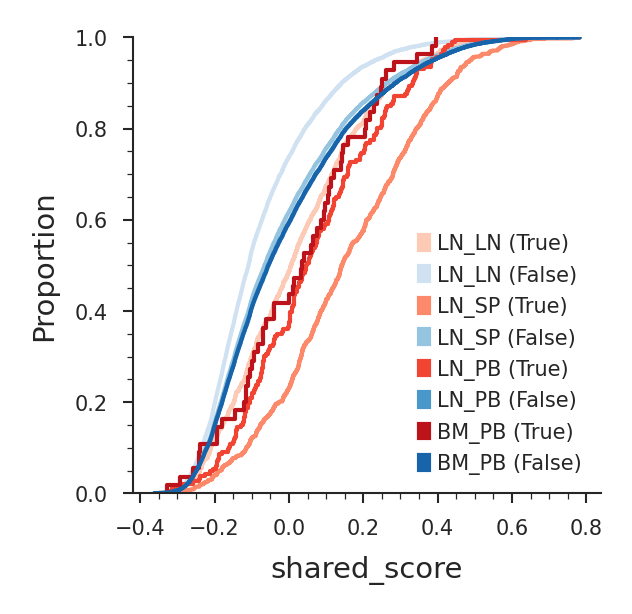

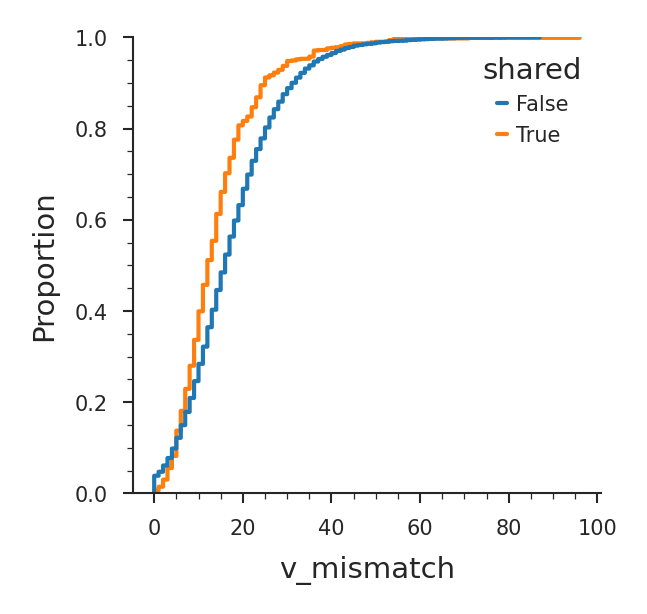

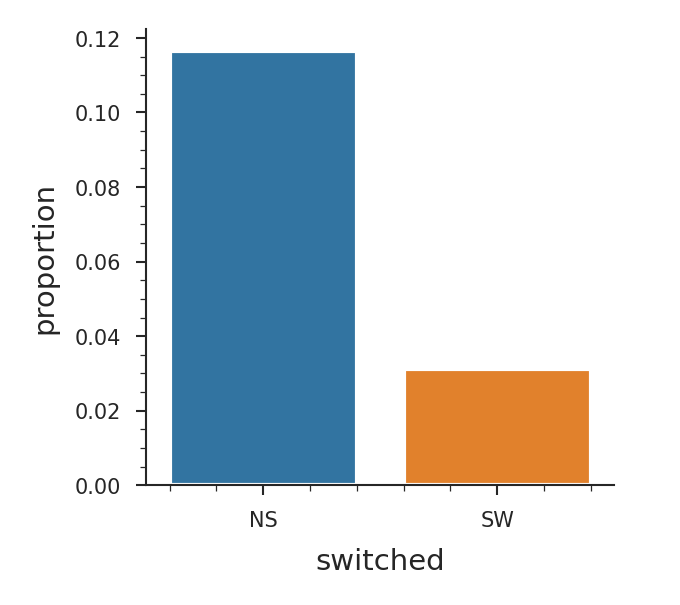

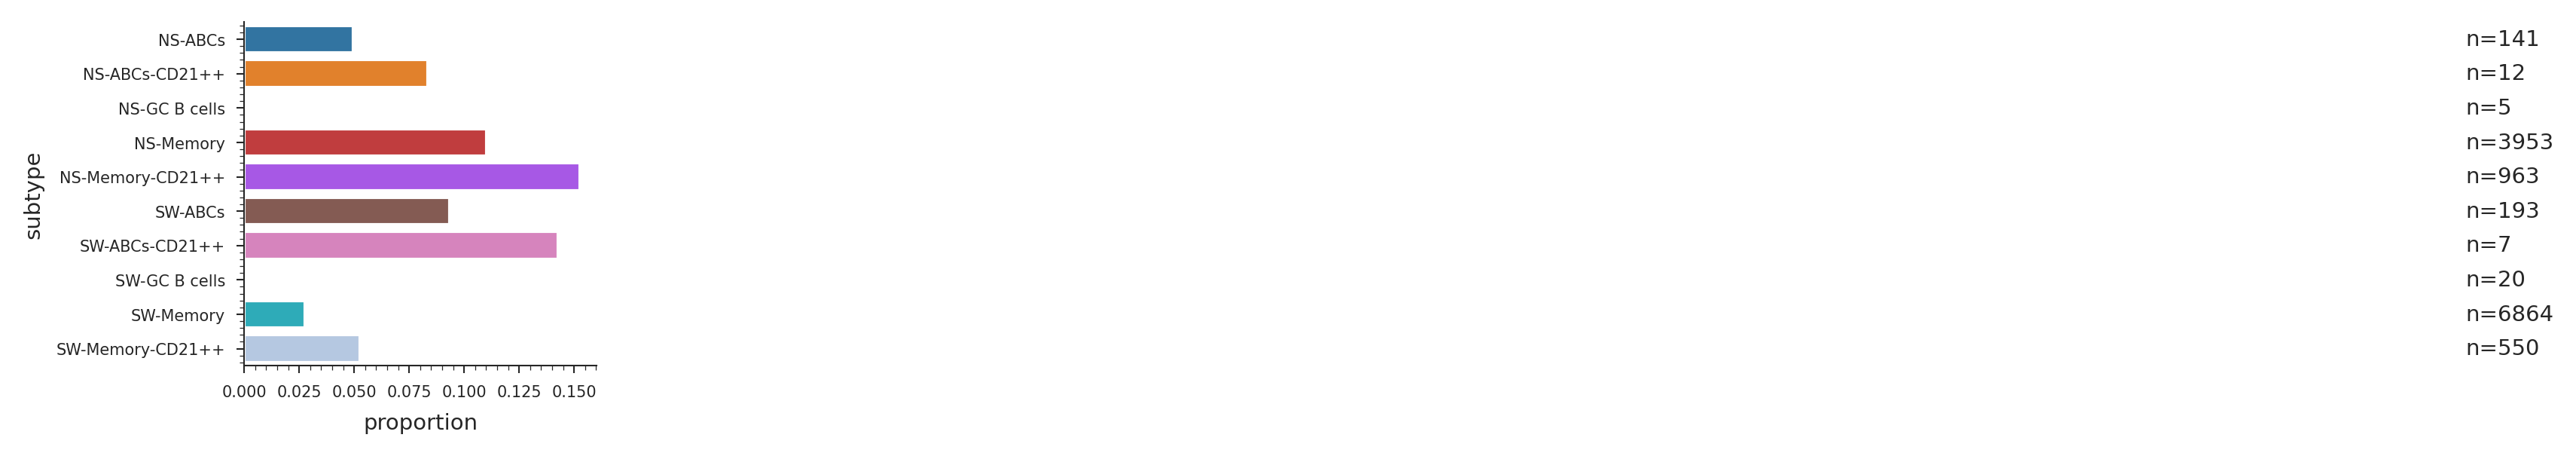

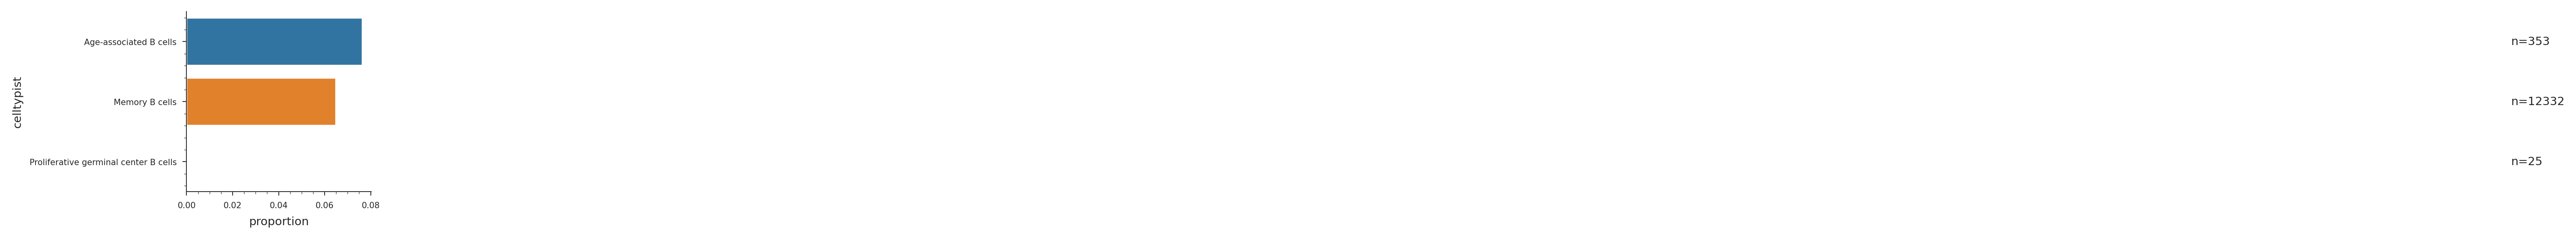

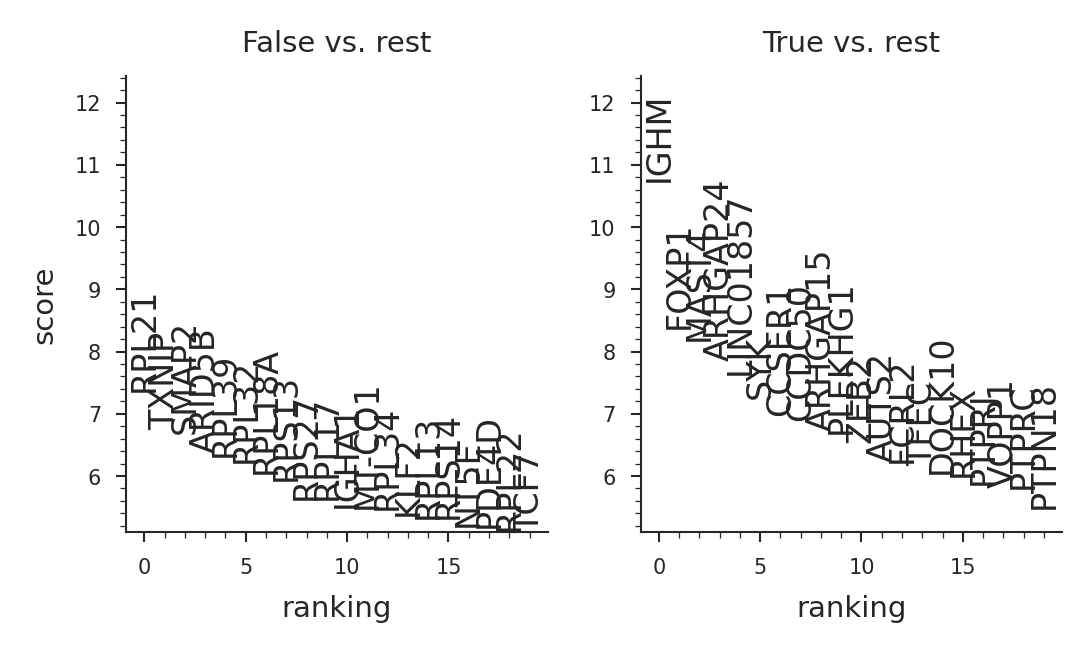

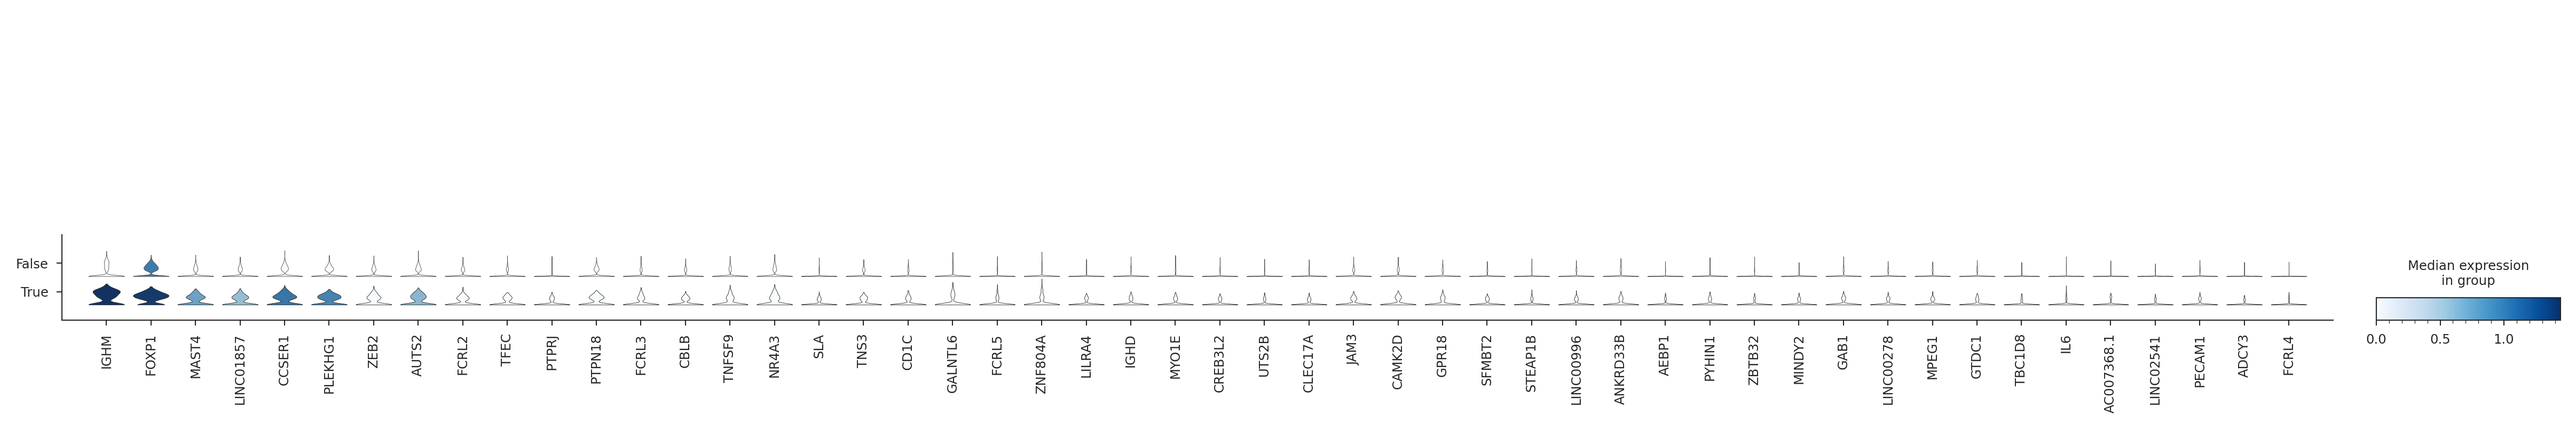

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


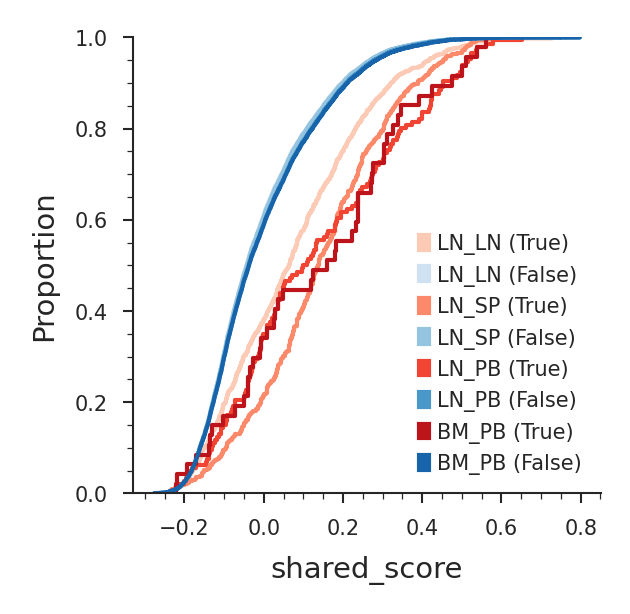

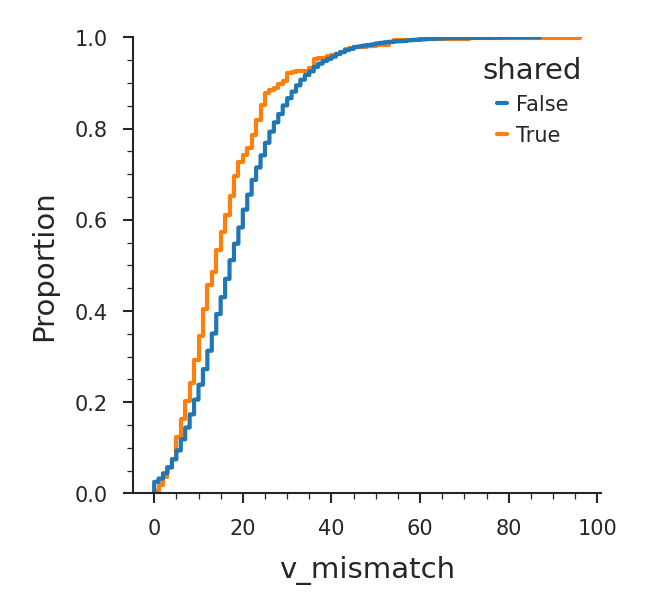

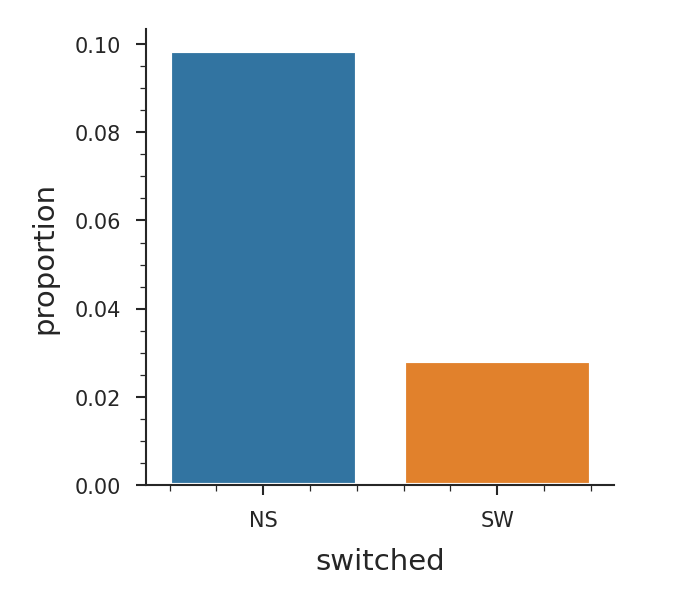

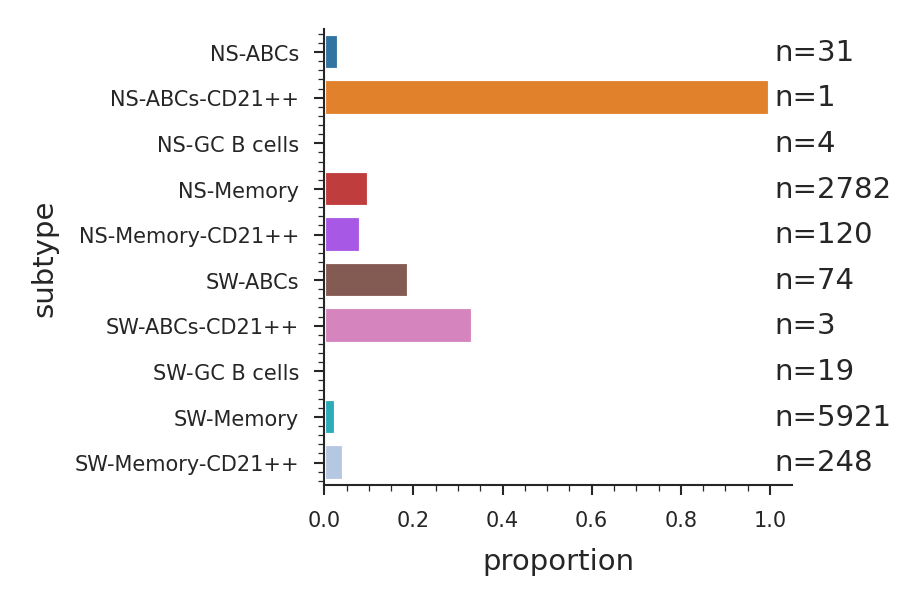

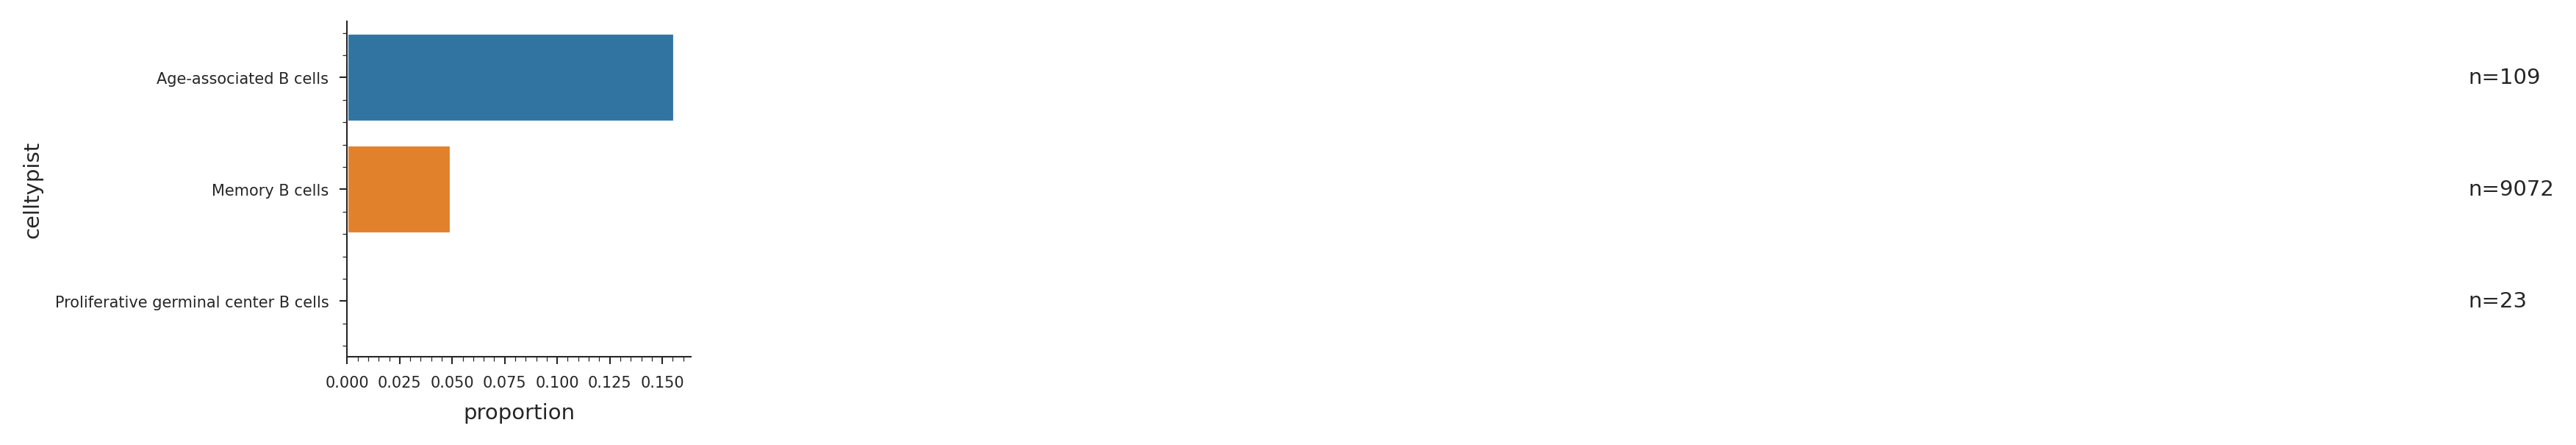

In [7]:
# Dictionary to hold AnnData objects and their descriptors
adata_dict = {'all_data': adata, 'all_tissues_mb': mb_adata, 'LN_only': mb_adata_LN}
# Loop through the dictionary
for descriptor, ad in adata_dict.items():
    # Perform ranking of genes
    #sc.tl.rank_genes_groups(ad, groupby='shared', method='logreg', max_iter=1000, key_added='shared_logistic')
    sc.tl.rank_genes_groups(ad, groupby='shared', method = 'wilcoxon', key_added='shared')    
    # Plot ranked genes
    sc.pl.rank_genes_groups(ad, key='shared')
    
    # Get the DataFrame of ranked genes
    dedf = sc.get.rank_genes_groups_df(ad, group="True", key='shared')
    
    # Filter the DataFrame based on logfoldchanges
    dedf_filtered = dedf[dedf.logfoldchanges > 0.69]
    dedf_filtered.to_csv(f"{tissue_combo}_{descriptor}_de_genes.tab", sep = '\t')
    # Get the top 30 genes
    gene_list = dedf_filtered.names[:50]
    
    # Generate the figure name based on the dataset descriptor
    figure_name = f'shared_{descriptor}'
    
    # Create the stacked violin plot and save it
    sc.pl.stacked_violin(ad, var_names=gene_list, groupby='shared', save=f'{figure_name}.png')

    sc.tl.score_genes(ad, gene_list=gene_list, score_name='shared_score', use_raw=True)
    

    import matplotlib.patches as mpatches

    # Create separate color iterators for True and False
    true_colors = iter(sns.color_palette("Reds", n_colors=len(tissue_combo_to_column)))
    false_colors = iter(sns.color_palette("Blues", n_colors=len(tissue_combo_to_column)))

    # Create a color mapping for each tissue_combo
    color_mapping = {}
    for tissue_combo in tissue_combo_to_column.keys():
        color_mapping[tissue_combo] = {True: next(true_colors), False: next(false_colors)}

    data = ad.obs

    # Initialize the plot
    fig, ax = plt.subplots(1, 1)

    # Initialize an empty list to hold the custom legend handles
    legend_handles = []

    # Plot ECDF for each tissue_combo with its unique pair of colors
    for tissue_combo, columns in tissue_combo_to_column.items():
        sns.ecdfplot(
            data=data, 
            x='shared_score', 
            hue=columns, 
            ax=ax, 
            palette=color_mapping[tissue_combo]
        )
        
        # Add custom legend entries
        for truth_value, color in color_mapping[tissue_combo].items():
            label = f"{tissue_combo} ({truth_value})"
            handle = mpatches.Patch(color=color, label=label)
            legend_handles.append(handle)

    # Add the custom legend to the plot
    ax.legend(handles=legend_handles)

    # Save the figure
    save_figure(fig, f"{figure_name}_score_ecdf")

    # hypermutation:
    data = ad.obs
    fig, ax = plt.subplots(1,1)
    sns.ecdfplot(data=data, x = 'v_mismatch', hue = 'shared', ax = ax)
    save_figure(fig, f"v_mismatch_{figure_name}")

    # switched status:
    group = 'switched'
    data = ad.obs.groupby([group]).shared.value_counts(normalize=True)
    data = data.reset_index()

    plot_df = data[data.shared == True]
    fig, ax = plt.subplots(1,1)
    sns.barplot(data=plot_df, x = group, y = 'proportion', ax = ax)
    ax.legend(bbox_to_anchor=(1.1,1))
    save_figure(fig, f"{group}_{figure_name}")

    # subtype
    try:
        group = 'subtype'
        data = ad.obs.groupby([group]).shared.value_counts(normalize=True)
        data = data.reset_index(name='proportion')

        # Filter data for shared == True
        plot_df = data[data.shared == True]

        # Create the barplot
        fig, ax = plt.subplots(1, 1)
        sns.barplot(data=plot_df, y=group, x='proportion', ax=ax)
        # Calculate the total number of observations for each group
        total_counts = ad.obs[group].value_counts().sort_index()

        # Add the total number of observations for each group to the plot
        for index, value in enumerate(total_counts):
            ax.text(1.01, index, f'n={value}', verticalalignment='center')

        # Save the figure
        save_figure(fig, f"{group}_{figure_name}")

    except KeyError:
        print("probably no subtype information in this adata")


    # subtype
    try:
        group = 'celltypist'
        data = ad.obs.groupby([group]).shared.value_counts(normalize=True)
        data = data.reset_index(name='proportion')

        # Filter data for shared == True
        plot_df = data[data.shared == True]

        # Create the barplot
        fig, ax = plt.subplots(1, 1)
        sns.barplot(data=plot_df, y=group, x='proportion', ax=ax)
        # Calculate the total number of observations for each group
        total_counts = ad.obs[group].value_counts().sort_index()

        # Add the total number of observations for each group to the plot
        for index, value in enumerate(total_counts):
            ax.text(1.01, index, f'n={value}', verticalalignment='center')

        # Save the figure
        save_figure(fig, f"{group}_{figure_name}")
    except KeyError:
        print("probably no subtype information in this adata")


In [8]:
# canonical markers for plotting
canonical_markers = ['MS4A1', "CD19", 'CD27', 'CD24', 'NT5E', 
                     "CD86", "IGHD", "ITGAX", "SOX5", "LGALS1", "DUSP1", "TCL1A"]
# selected transcriptional markers
transcriptional_markers = ["IGHM", "MAST4", "SYK", "CCDC50", "TFEC", 'ZEB2', 'CD1C']
markers =  list(set(canonical_markers + transcriptional_markers))
# Style
sns.set_style("ticks")
plt.style.use('../bursa.mplstyle')
# dot plot creation
dp = sc.pl.DotPlot(mb_adata_LN, markers, groupby= 'shared', figsize = (2, 2.2), vmax = 2, vmin = 0,  expression_cutoff = 0)
dp.legend(width=0.8)
dp.swap_axes()
dp.add_totals(color = '0.4', size = 0.3,).style(dot_edge_color='black', largest_dot = 40 , dot_edge_lw=0.2, cmap = 'Purples').show()

# get axes for tweaking out
axes = dp.get_axes()

for child in axes['group_extra_ax'].get_children():
    if isinstance(child, mpl.text.Annotation):
       # print("bingo") # and do something
       # print(round_string(child.get_text()))
        child.set(rotation=90, verticalalignment='bottom')
       # print(child)
# First, remove the current title
axes['size_legend_ax'].set_title("")
axes['size_legend_ax'].tick_params(axis='x', which = 'minor', length=0)
axes['size_legend_ax'].tick_params(axis='x', labelsize=5)

# Then, create a new title using a text object
title = "% cells\nexpression > 0"
axes['size_legend_ax'].text(0, 0.8, title, transform=axes['size_legend_ax'].transAxes, 
                            va='center', ha='left', fontsize = 5)

title = "Mean Expression\n($log_2$ UMI per 10K)"
axes['color_legend_ax'].set_title("")
axes['color_legend_ax'].text(0, 2.2, title, transform=axes['color_legend_ax'].transAxes, 
                            va='center', ha='left', fontsize = 5)
axes['color_legend_ax'].tick_params(axis='x', labelsize=5)

# Get the bounding box of the main plot
mainplot_box = axes['mainplot_ax'].get_position()
for bar in axes['group_extra_ax'].patches:
    bar.set_edgecolor('none')
ax = axes['mainplot_ax']
# add label
y_text_loc = ax.get_yticks()[(len(canonical_markers)) - 5]
x_text_loc = ax.get_xticks()[-1] + 1
ax.text(x_text_loc, y_text_loc, 'Canonical', rotation=-90, fontsize = 6)
# add label
y_text_loc = ax.get_yticks()[13] + 4.5
x_text_loc = ax.get_xticks()[-1] + 1
ax.text(x_text_loc, y_text_loc, 'Data-Derived', rotation=-90, fontsize = 6)
#save_figure(dp.fig, f"dotplot_{celltype}")

# Do some ML models to understand how distinguishable these classes are and what features are most important

In [11]:
# create column for whether any memory B cell is shared between any of the tissue combos
ad = mb_adata
use_LN_LN = True
if use_LN_LN:
    ad.obs.shared = ad.obs[tissue_combo_to_column['LN_LN']]
# binarize
ad.obs.shared = ad.obs.shared > 0
print(ad.obs.shared.value_counts().xs(True), "shared B cells")
print(ad.obs.shared.value_counts().xs(False), "not shared B cells")

1022 shared B cells
11688 not shared B cells


In [12]:
clf_data = "classifier_data.tab"
feature_genes = gene_list.to_list()
genes = set(feature_genes + canonical_markers)
df = sc.get.obs_df(ad, keys= feature_genes + canonical_markers + ['subtype', 'switched', 'v_mismatch', 'shared'])
df.to_csv(clf_data, sep = '\t')

Random Forest Accuracy: 0.6014669926650367
Random Forest Classification Report:               precision    recall  f1-score   support

       False       0.63      0.56      0.59       212
        True       0.58      0.64      0.61       197

    accuracy                           0.60       409
   macro avg       0.60      0.60      0.60       409
weighted avg       0.60      0.60      0.60       409

Logistic Regression Accuracy: 0.5696821515892421
Logistic Regression Classification Report:               precision    recall  f1-score   support

       False       0.59      0.57      0.58       212
        True       0.55      0.57      0.56       197

    accuracy                           0.57       409
   macro avg       0.57      0.57      0.57       409
weighted avg       0.57      0.57      0.57       409



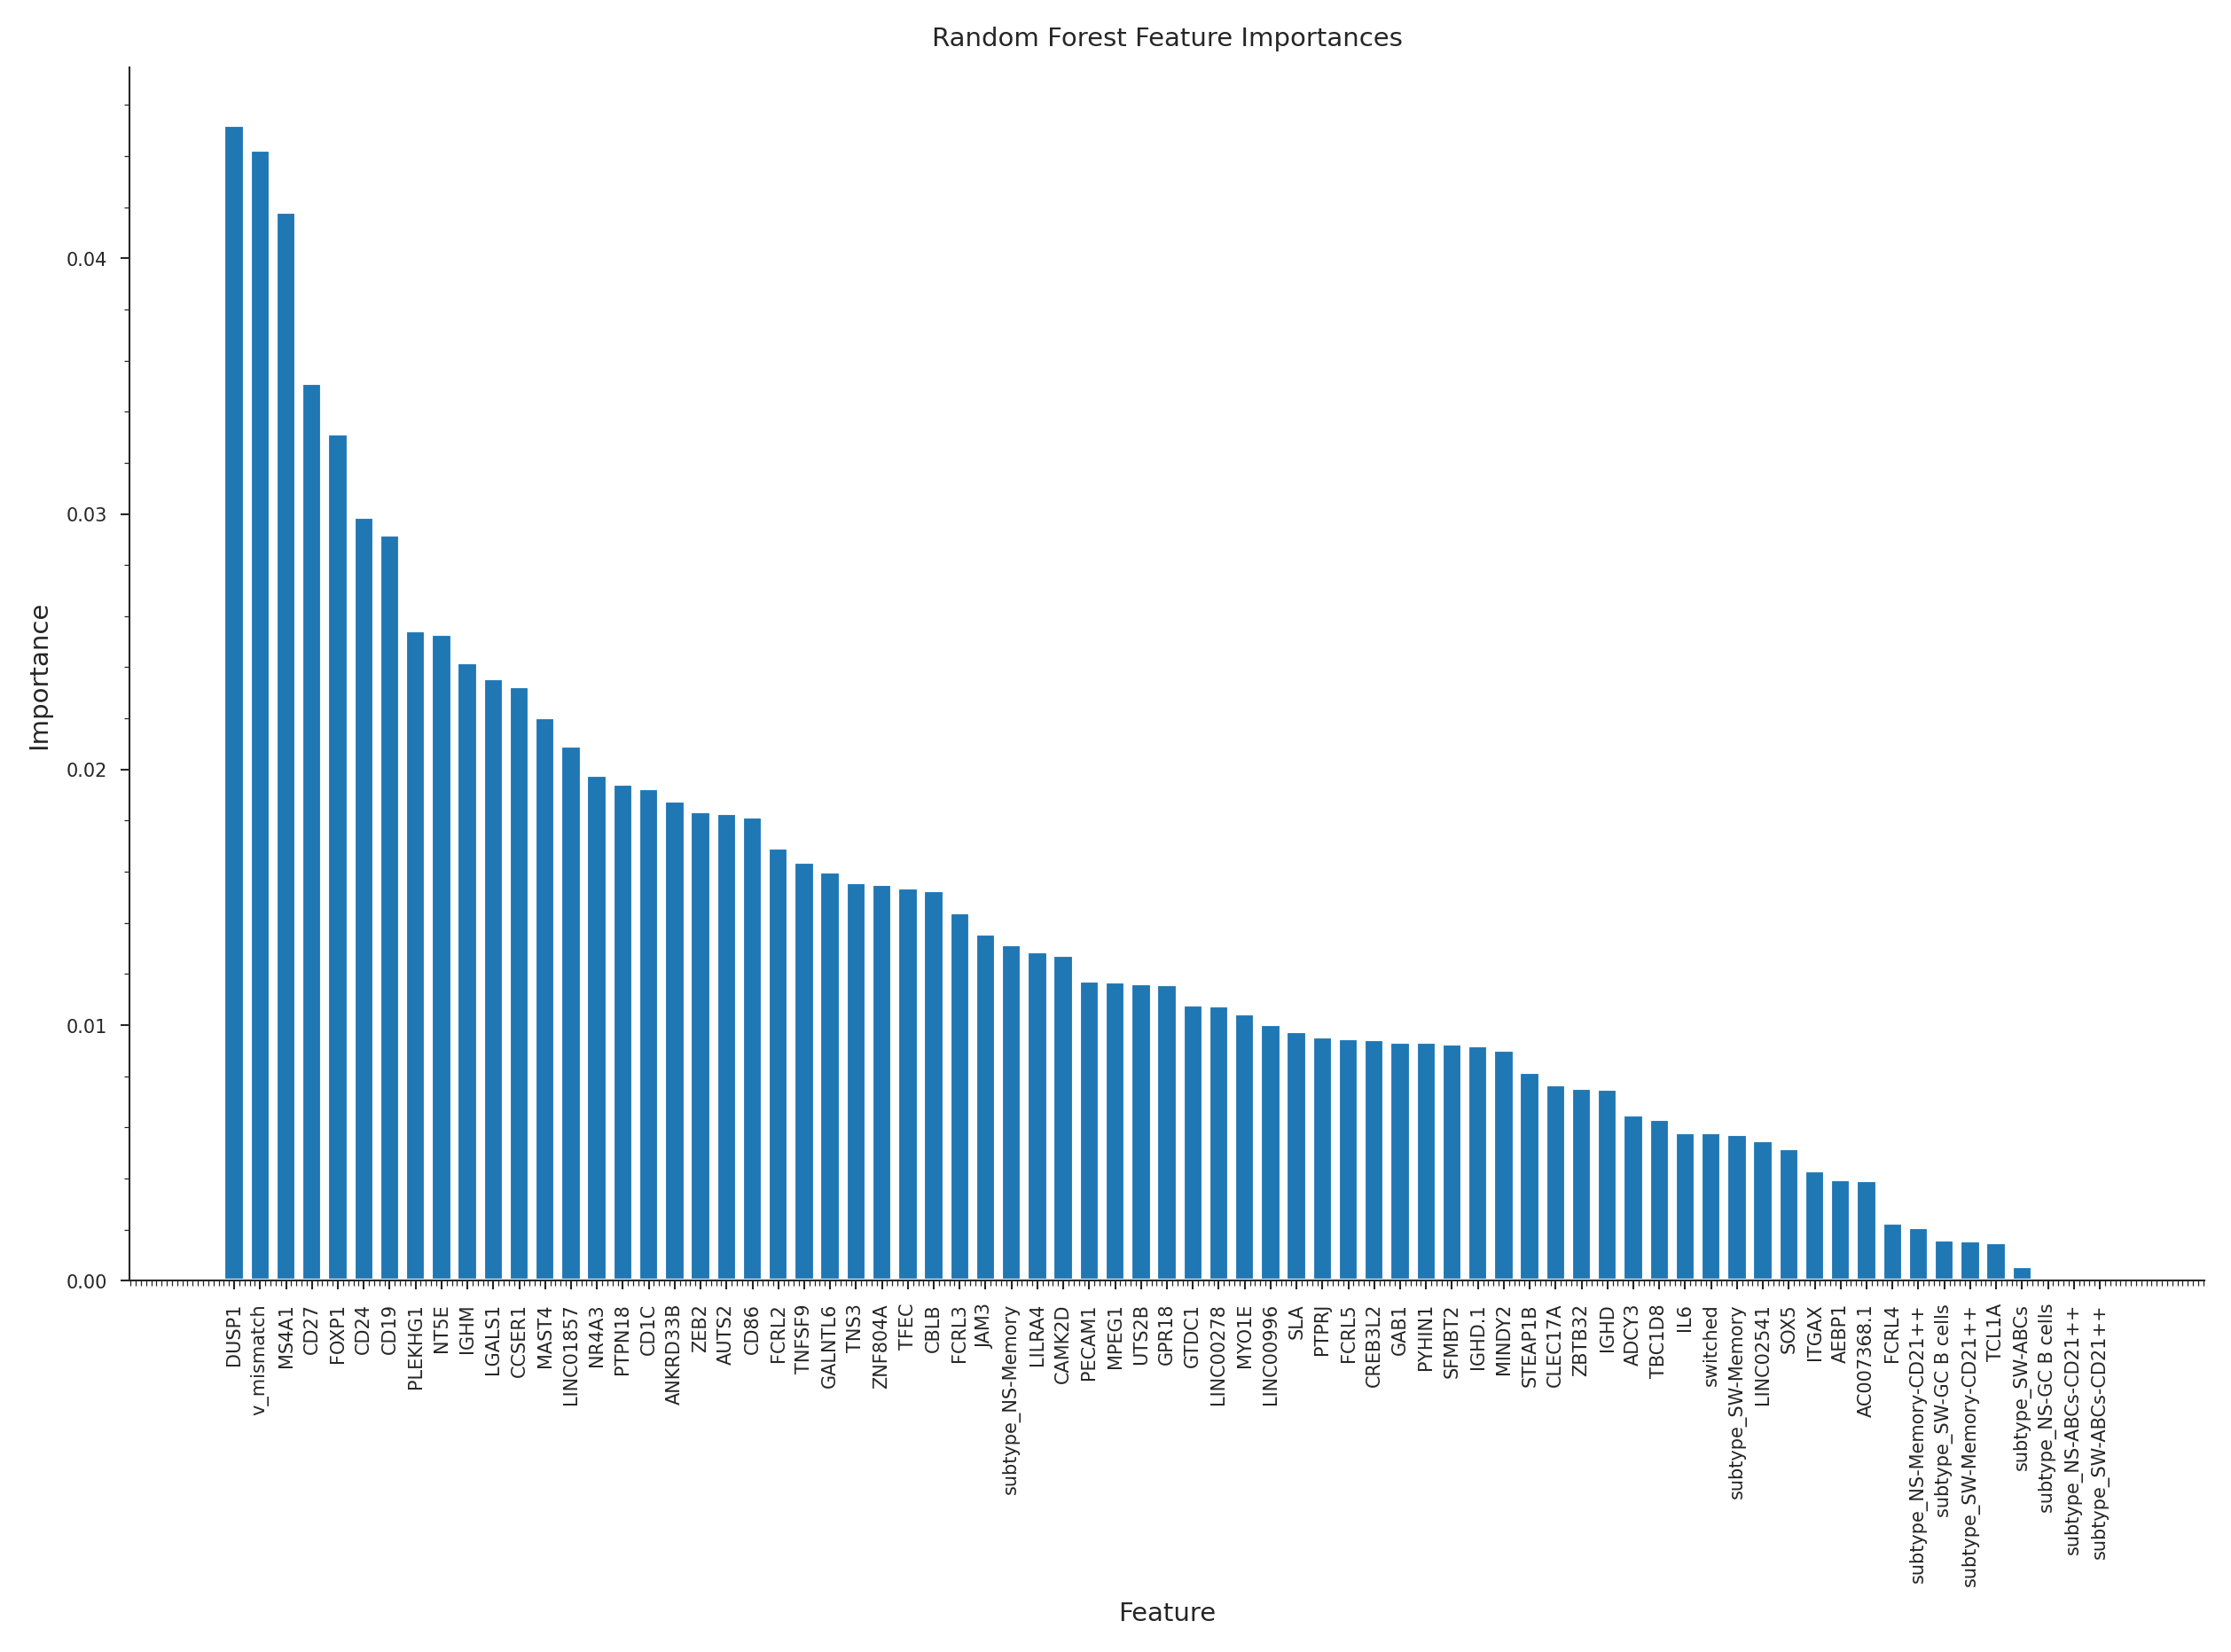

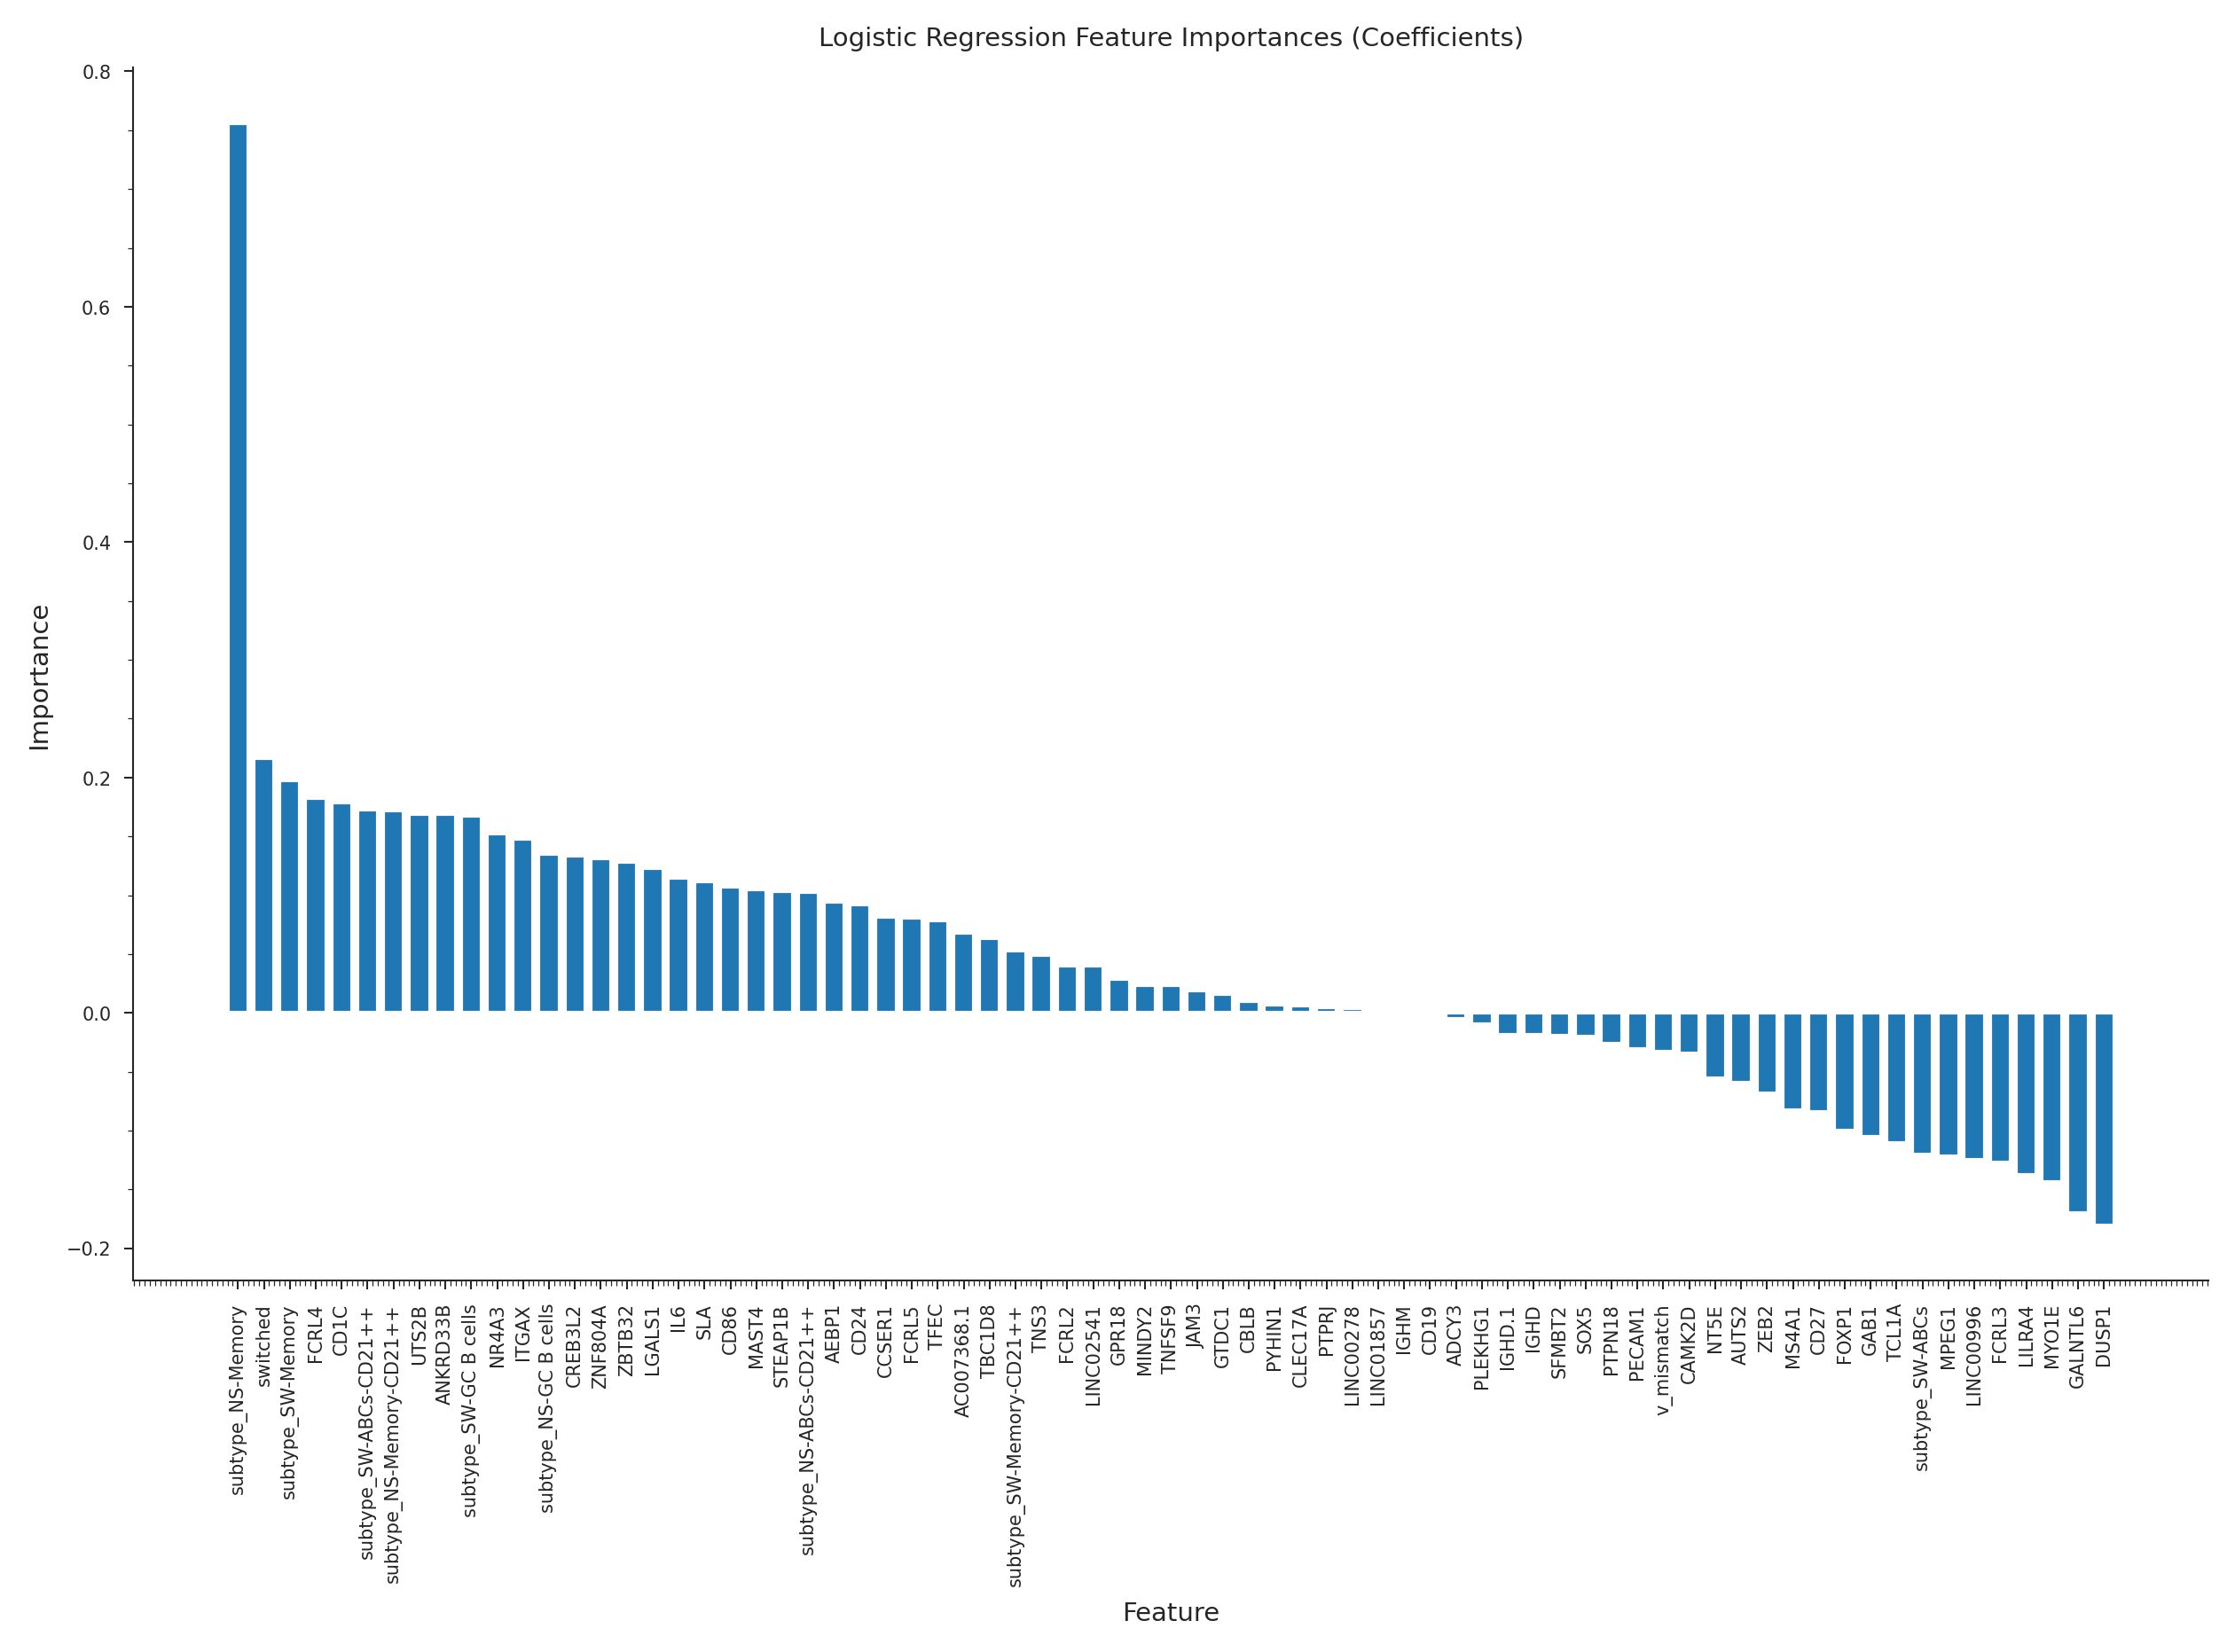

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Function to plot feature importances
def plot_feature_importances(importances, feature_names, title):
    sorted_indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[sorted_indices], align='center')
    plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()

# Load the dataset
df = pd.read_table(clf_data)

# Drop index column
df = df.drop(columns=['cb_suid'])

# Label encode 'switched'
label_encoder = LabelEncoder()
df['switched'] = label_encoder.fit_transform(df['switched'])

# One-hot encode 'celltypist'
df = pd.get_dummies(df, columns=['subtype'], drop_first=True)


# Count the number of occurrences of each class
class_counts = df['shared'].value_counts()

# Identify the majority and minority classes
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Separate the data by class
df_majority = df[df['shared'] == majority_class]
df_minority = df[df['shared'] == minority_class]

# Undersample the majority class
df_majority_undersampled = df_majority.sample(len(df_minority))

# Concatenate the majority-undersampled and minority dataframes
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the DataFrame
df_undersampled = df_undersampled.sample(frac=1).reset_index(drop=True)

# Split the dataset into features (X) and target variable (y)
X = df_undersampled.drop('shared', axis=1)
y = df_undersampled['shared']

# Scale the features for clustering and logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Evaluate Random Forest
rf_y_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_classification_rep = classification_report(y_test, rf_y_pred)

# Feature importances for Random Forest
rf_feature_importances = rf_clf.feature_importances_

# Initialize and train Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Evaluate Logistic Regression
log_y_pred = log_reg.predict(X_test)
log_accuracy = accuracy_score(y_test, log_y_pred)
log_classification_rep = classification_report(y_test, log_y_pred)

# Feature importances for Logistic Regression (coefficients)
log_feature_importances = log_reg.coef_[0]

# Print evaluation metrics
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:", rf_classification_rep)
print("Logistic Regression Accuracy:", log_accuracy)
print("Logistic Regression Classification Report:", log_classification_rep)

# Plot feature importances
plot_feature_importances(rf_feature_importances, X.columns, 'Random Forest Feature Importances')
plot_feature_importances(log_feature_importances, X.columns, 'Logistic Regression Feature Importances (Coefficients)')


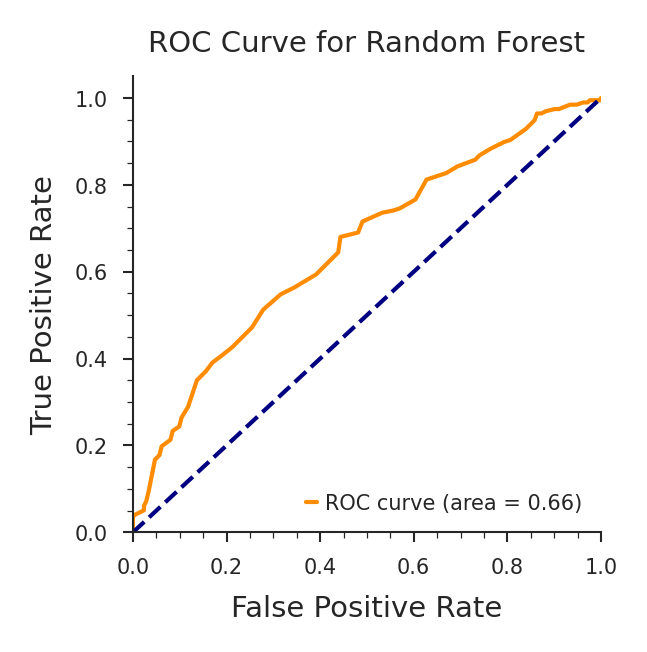

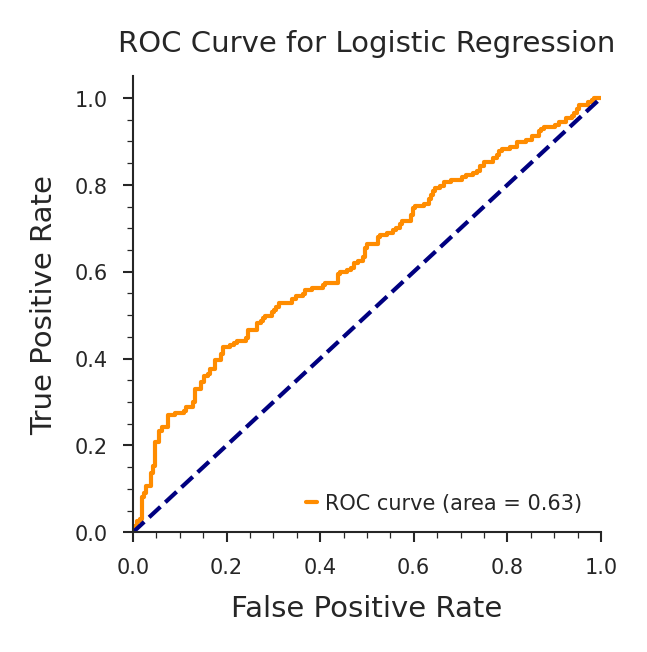

In [14]:
from sklearn.metrics import roc_curve, auc
# Function to plot ROC curve and AUC
def plot_roc_auc(y_test, y_pred_prob, model_name):

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    roc_auc = auc(fpr, tpr)

    plt.figure()

    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = {:.2f})'.format(roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

    plt.xlim([0.0, 1.0])

    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title(f'ROC Curve for {model_name}')

    plt.legend(loc="lower right")

    plt.show()



# Add these lines after fitting and evaluating the Random Forest and Logistic Regression models



# Predict probabilities for Random Forest

rf_y_pred_prob = rf_clf.predict_proba(X_test)[:, 1]



# Predict probabilities for Logistic Regression

log_y_pred_prob = log_reg.predict_proba(X_test)[:, 1]



# Plot ROC curve and AUC for Random Forest

plot_roc_auc(y_test, rf_y_pred_prob, 'Random Forest')


# Plot ROC curve and AUC for Logistic Regression

plot_roc_auc(y_test, log_y_pred_prob, 'Logistic Regression')

### Finish: find some to way to compare putative shared GEX profiles for each tissue combo, we want to demonstrate there appears to be a pan-tissue signature which indicates you are likely a shared clone.

- This can simply be the correlation map of the different "shared" cells from each tissue combo or even tissue in the chosen feature space. 

- Additionally, can show the classification of "shared" using a model built exclusively on e.g. LN_LN, on the ability to classify LN_SP sharing or LN_PB sharing or BM_PB sharing



I think it has become quite clear that the non-switch memory B cell clones is in some way most likely to be shared. I think there remains 2 explanations:
1. the NS memory cells are less diverse as a cell subset, so by conditioning on exact VDJ matches, we make it more likely to detect shared NS memory cells
    - one way to test this idea would be to use lineage_id as the shared marker instead
    - one thing which argues agains this idea (slightly) is that if you don't remove plasma cells, they are actually the most likely to be shared
    

In [36]:
data = mb_adata.obs.groupby(['subtype','vdj_sequence']).size()

In [37]:
data = pd.DataFrame(data).reset_index()

<Axes: xlabel='0', ylabel='Count'>

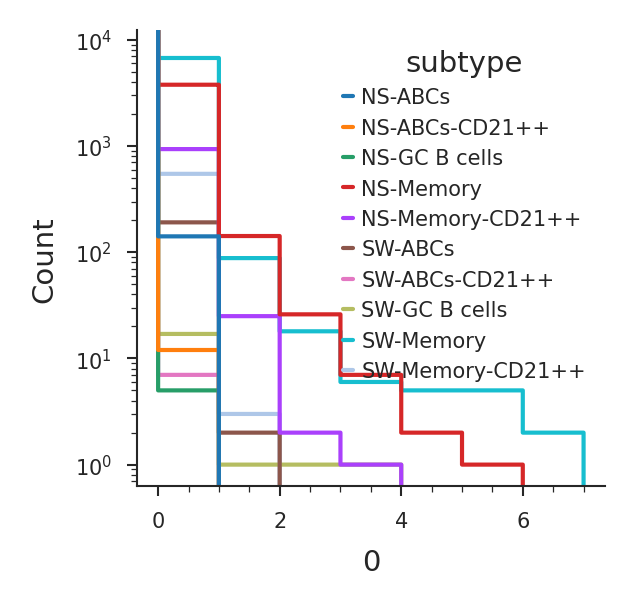

In [39]:
sns.ecdfplot(data=data, x=0, complementary=True, log_scale=(False,True), hue = 'subtype', stat = 'count')

In [15]:
# compare DE genes from each combo:

# Dictionary to hold AnnData objects and their descriptors
adata_dict = {'all_data': adata, 'all_tissues_mb': mb_adata, 'LN_only': mb_adata_LN}
# load each dedf written by dedf_filtered.to_csv(f"{output_dir}/{tissue_combo}/{descriptor}_de_genes.tab", sep = '\t')

# concatenate dedf's adding a column indicating 'descriptor'
